<div style="background-color:	#103060; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">NLP Vertaling van teksten</h1>
<b style="color:white">Rogier Gernaat</b>
    </div>

<a name='start'></a>

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Intro</strong>
</div>




BLABLABLA uitleggen waar NLP voor staat wat een tokenizer is etc etc voor school


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Downloaden van de benodigde library's</strong>
</div>




In [25]:
# !pip install transformers torch
# !pip install sentencepiece
# !pip install sacremoses
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install sklearn



  Using cached sklearn-0.0.post9.tar.gz (3.6 kB)
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn: started
    Running setup.py install for sklearn: finished with status 'done'


    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\rogie\OneDrive\Bureaublad\Git-Clone-Stage\Stage-map\myvenv\Scripts\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\rogie\\AppData\\Local\\Temp\\pip-install-zefbcguo\\sklearn_f42fe04ef69e4d01b8c164a28d8f77d7\\setup.py'"'"'; __file__='"'"'C:\\Users\\rogie\\AppData\\Local\\Temp\\pip-install-zefbcguo\\sklearn_f42fe04ef69e4d01b8c164a28d8f77d7\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\rogie\AppData\Local\Temp\pip-pip-egg-info-m8salur9'
         cwd: C:\Users\rogie\AppData\Local\Temp\pip-install-zefbcguo\sklearn_f42fe04ef69e4d01b8c164a28d8f77d7\
    Complete output (15 lines):
    The 'sklearn' PyPI package is deprecated, 

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Inladen van modules en library's</strong>
</div>




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from transformers import MarianMTModel, MarianTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import sentencepiece
from transformers import AdamW
import torch


c:\Users\rogie\OneDrive\Bureaublad\Git-Clone-Stage\Stage-map\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Initializeren van het model en de tokenizer</strong>
</div>




In [2]:
# Initialiseer tokenizer en model
model_name = 'Helsinki-NLP/opus-mt-nl-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Testen van het pretrained model</strong>
</div>




In [3]:
# Voorbeeldzin om te testen
test_sentence = "Ik ben Rogier Gernaat, student aan de Haagse Hogeschool en studeer Applied Data Science & AI. Ik loop mijn stage bij SamenGezondZoeterMeer en werk aan het verzamelen van preventieve gezondheidsinitiatieven rond Zoetermeer."

# Standaard vertaling met gepretrainde model
inputs = tokenizer(test_sentence, return_tensors="pt")
outputs = model.generate(**inputs)
translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Vertaling met standaard model:", translated_text)


Vertaling met standaard model: I am Rogier Gernaat, a student at the Hague University of Applied Data Science & AI. I am doing my internship at TogetherGezondZooterMore and work on collecting preventive health initiatives around Zoetermeer.


We zien hier al een redelijk solide vertaling met het enige probleem dat hij waarschijnlijk sommige bedrijfsnamen niet genoemgd zijn in de pretrained dataset waardoor je rare variaties van vertaling gaat krijgen zoals "TogetherGezondZooterMore". Hier heb ik het idee om finetune data toe te voegen aan het al bestaande pretrained model om te kijken of ik hierdoor kleine fouten kan oplossen

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Mini-dataset gemaakt voor het finetunen van het pretrained model</strong>
</div>




In [4]:
fine_tune_data = [
    # Gezondheidsgerelateerde zinnen
    {"nl": "Hoe kan ik mijn gezondheid verbeteren?", "en": "How can I improve my health?"},
    {"nl": "Welke stappen kan ik nemen voor een gezondere levensstijl?", "en": "What steps can I take for a healthier lifestyle?"},
    {"nl": "Regelmatige lichaamsbeweging kan helpen om gezond te blijven.", "en": "Regular exercise can help to stay healthy."},
    {"nl": "Gezonde voeding is essentieel voor een goede gezondheid.", "en": "Healthy eating is essential for good health."},
    {"nl": "Het is belangrijk om genoeg water te drinken.", "en": "It is important to drink enough water."},
    {"nl": "Hoeveel uur slaap heb ik per nacht nodig?", "en": "How many hours of sleep do I need per night?"},
    {"nl": "Stress verminderen kan bijdragen aan een betere gezondheid.", "en": "Reducing stress can contribute to better health."},
    
    # Activiteiten en evenementen
    {"nl": "Welke activiteiten zijn er beschikbaar?", "en": "What activities are available?"},
    {"nl": "Dit evenement is geschikt voor alle leeftijden.", "en": "This event is suitable for all ages."},
    {"nl": "Zijn er groepsactiviteiten voor ouderen?", "en": "Are there group activities for the elderly?"},
    {"nl": "Er is een wekelijkse wandeling op dinsdagochtend.", "en": "There is a weekly walk on Tuesday mornings."},
    {"nl": "Je kunt je inschrijven voor verschillende workshops.", "en": "You can register for various workshops."},
    {"nl": "Is er een maximum aantal deelnemers voor dit evenement?", "en": "Is there a maximum number of participants for this event?"},
    
    # Algemene informatieve zinnen
    {"nl": "Waar kan ik meer informatie vinden over preventieve zorg?", "en": "Where can I find more information about preventive care?"},
    {"nl": "De kosten voor dit programma zijn gratis.", "en": "The cost for this program is free."},
    {"nl": "Hoe kan ik me aanmelden voor deze cursus?", "en": "How can I sign up for this course?"},
    {"nl": "Deze website biedt informatie over verschillende gezondheidsonderwerpen.", "en": "This website provides information on various health topics."},
    {"nl": "Zijn er online bronnen die ik kan raadplegen?", "en": "Are there online resources that I can consult?"},
    {"nl": "Kan ik telefonisch contact opnemen voor vragen?", "en": "Can I contact by phone for questions?"},
    {"nl": "Er zijn meerdere locaties beschikbaar voor deze diensten.", "en": "There are multiple locations available for these services."},
    {"nl": "Wat zijn de werktijden van de SamenGezondZoeterMeer helpdesk?", "en": "What are the working hours of the SamenGezondZoeterMeer helpdesk?"},
]

#Eventueel uitbreiden met meer specifieke zinnen/data


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Class voor het finetunen van de pretrained model</strong>
</div>




In [5]:
class TranslationDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        nl_text = self.data[idx]["nl"]
        en_text = self.data[idx]["en"]
        inputs = self.tokenizer(nl_text, return_tensors="pt", padding="max_length", max_length=128, truncation=True)
        targets = self.tokenizer(en_text, return_tensors="pt", padding="max_length", max_length=128, truncation=True)
        inputs["labels"] = targets["input_ids"]
        return inputs

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Splitsen van de data in Train, Test en Validatie</strong>
</div>




In [6]:
# Split de data in train en validatie (bijvoorbeeld 80% train, 20% validatie)
train_data, val_data = train_test_split(fine_tune_data, test_size=0.2)
train_dataset = TranslationDataset(train_data, tokenizer)
val_dataset = TranslationDataset(val_data, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Trainen van het Model</strong>
</div>




In [7]:
train_losses = []
val_losses = []


# Stel de optimizer in
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop met validatie
for epoch in range(5):  # Stel het aantal epochs in
    model.train()
    epoch_train_loss = 0
    for batch in train_dataloader:
        input_ids = batch['input_ids'].squeeze(1)
        attention_mask = batch['attention_mask'].squeeze(1)
        labels = batch['labels'].squeeze(1)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    # Gemiddelde train loss van de epoch
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validatie
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].squeeze(1)
            attention_mask = batch['attention_mask'].squeeze(1)
            labels = batch['labels'].squeeze(1)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            epoch_val_loss += val_loss.item()

    # Gemiddelde val loss van de epoch
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


c:\Users\rogie\OneDrive\Bureaublad\Git-Clone-Stage\Stage-map\myvenv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 | Train Loss: 2.0505 | Val Loss: 0.9389
Epoch 2 | Train Loss: 0.8666 | Val Loss: 0.6766
Epoch 3 | Train Loss: 0.5195 | Val Loss: 0.5660
Epoch 4 | Train Loss: 0.4004 | Val Loss: 0.5079
Epoch 5 | Train Loss: 0.3210 | Val Loss: 0.4623


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Plotten van de Loss</strong>
</div>




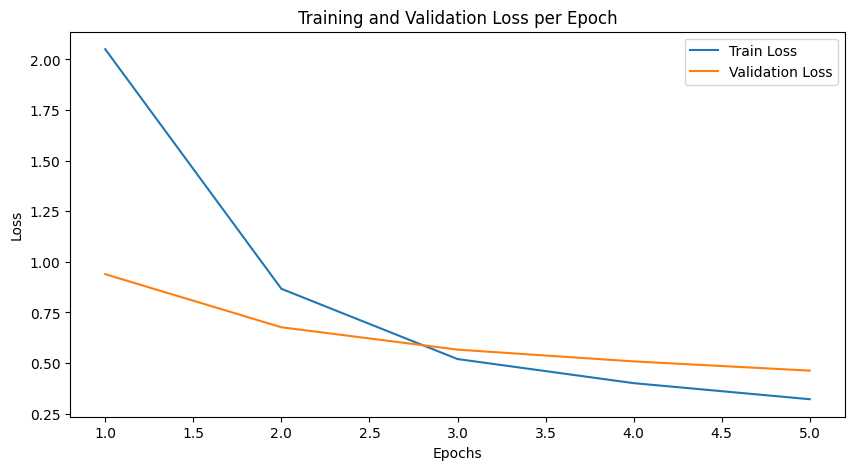

In [8]:
# Plot train en val loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.show()


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Testen op de nieuwe Finetuning van het model</strong>
</div>




In [25]:
# Test een nieuwe zin na finetuning
test_sentence = "Ik ben Rogier Gernaat, student aan de Haagse-Hogeschool en studeer ADS&AI. Ik loop mijn stage bij SamenGezondZoeterMeer en werk aan het verzamelen van preventieve/positieve gezondheidsinitiatieven rond zoetermeer"
inputs = tokenizer(test_sentence, return_tensors="pt")
outputs = model.generate(**inputs)
translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Vertaald na finetuning:", translated_text)


Vertaald na finetuning: I'm Rogier Gernaat, a student at the Haagse-Hogeschool and a student at ADS&AI. I'm doing my internship at ZemGezondZoeterMeer en het aan het aan het aan het aan het aan het aan het ameldiging van preventive/positive healthactities om sweetermeer.


##### We zien hier eigenlijk al snel dat hij opmerkelijk veel fouten gaat maken bijvoorbeeld:
* Geen engelse vertaling voor Haagse-Hogeschool
* Hij pakt "SamenGezondZoetermeer" bijna goed op alleen er staat "ZemGezondZoeterMeer"
* Verzamelen is vertaald met "ameldiging"
* Zoetermeer is "sweetermeer"

Ook krijgt hij na de eerste zin een soort kortsluiting waar hij nederlandse woorden achter elkaar genereerd

Dit is tot nu toe dus zeker niet het succes waar ik op hoopte en dit vraagt dus een andere aanpak, het pretrained model heeft nog significante betere resultaten dus ik zit zelf te denken aan 2 dingen
- Nummer 1: is het alleen toevoegen van meer data en niet verder erop te finetunen, hierbij zou ik dus wat algemene voorbeeld zinnen gaan testen uit mijn "Gescrapede data" en kijken of hier kleine fouten in voor komen, en het toevoegen van bedrijfsnamen rond zoetermeer zodat het model daar geen fouten mee maakt 
- Nummer 2: het model finetunen met een veeeel grotere dataset zoals UBUNTU of OPUS, hier kan ik dan nog een poging wagen om het pretrained model te verbeteren doordat het model dan ook meer algemene zinnen mee pakt in de data en ook uberhaubt een stuk meer informatie heeft om mee te werken

In [26]:
# Test een nieuwe zin na finetuning
test_sentence = "hoe kan ik mijn gezondheid verbeteren?"
inputs = tokenizer(test_sentence, return_tensors="pt")
outputs = model.generate(**inputs)
translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Vertaald na finetuning:", translated_text)

Vertaald na finetuning: oh, my god. oh, my god. oh, my god. oh, my god. oh, my god. oh, my god. oh, my god.


Deze is wel ergens erg grappig, maar dat betekent dat zelfs de zinnen die in mijn mini-dataset zitten niet goed worden vertaalt, ergens gaat het niet goed in mijn aanpak en ik zal dus verder moeten gaan zoeken naar een andere oplossingen voor het finetunen.

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Finetunen Met Grotere Dataset</strong></h2>
</div>
Deze stap maak ik vooral om te spelen met het model, na het testen met het pretrained model kwam ik er achter dat deze al eigenlijk vrijwel goed transleert met heel af en toe een taal fout tussendoor. Om te kijken of ik het pretrained model nog iets beter kan maken ga ik hem proberen te optimaliseren doormiddel van een grote dataset gehaald van OPUS en hierbij ga ik ook nog testen of ik bedrijfsnamen die vaker gebruikt kunnen worden in mijn opdracht proberen toe te voegen zodat deze ook correct zouden worden getransleert in de vertaalde text.

In [16]:
# Paden naar de Engelse en Nederlandse bestanden
en_file_path = r'C:\Users\rogie\OneDrive\Bureaublad\Git-Clone-Stage\Stage-map\Tatoeba.en-nl.en'
nl_file_path = r'C:\Users\rogie\OneDrive\Bureaublad\Git-Clone-Stage\Stage-map\Tatoeba.en-nl.nl'

data = []
with open(en_file_path, 'r', encoding='ISO-8859-1') as en_file, open(nl_file_path, 'r', encoding='ISO-8859-1') as nl_file:
    for en_line, nl_line in zip(en_file, nl_file):
        # Verwijder overbodige spaties en nieuwe regels
        en_text = en_line.strip()
        nl_text = nl_line.strip()
        
        # Voeg het Engelse-Nederlandse zinnenpaar toe aan de lijst
        data.append({"en": en_text, "nl": nl_text})

# Controleer het aantal zinnen
print(f"Totaal aantal zinnen geladen: {len(data)}")

# Optioneel: Gebruik een subset van bijvoorbeeld 5000 zinnen voor finetuning
import random
fine_tune_data = random.sample(data,5000)

# Voorbeeld van de eerste paar zinnen
print("Voorbeeld van ingelezen data:", fine_tune_data[:5])


Totaal aantal zinnen geladen: 79548
Voorbeeld van ingelezen data: [{'en': '"Do you have any siblings?" "No, I\'m an only child."', 'nl': '"Heb je broers of zussen?" "Neen, ik ben enig kind."'}, {'en': 'The square is full of bicycles.', 'nl': 'Het plein staat vol met fietsen.'}, {'en': 'Do you have pencils?', 'nl': 'Heb jij potloden?'}, {'en': 'I can speak French and I can also speak English.', 'nl': 'Ik kan Frans praten en ik kan ook Engels praten.'}, {'en': "Tom didn't know that Mary could speak French.", 'nl': 'Tom wist niet dat Mary Frans kende.'}]


In [17]:
finetune_df = pd.DataFrame(fine_tune_data)
display(finetune_df)

,en,nl
0,"""Do you have any siblings?"" ""No, I'm an only c...","""Heb je broers of zussen?"" ""Neen, ik ben enig ..."
1,The square is full of bicycles.,Het plein staat vol met fietsen.
2,Do you have pencils?,Heb jij potloden?
3,I can speak French and I can also speak English.,Ik kan Frans praten en ik kan ook Engels praten.
4,Tom didn't know that Mary could speak French.,Tom wist niet dat Mary Frans kende.
...,...,...
4995,I don't think I have to tell you why.,Ik denk niet dat ik je hoef te vertellen waarom.
4996,Tom doesn't think that Mary's performance was ...,Tom vond Mary's optreden niet erg goed.
4997,I live in the country.,Ik woon op het platteland.
4998,The storm destroyed the whole town.,De storm heeft de hele stad verwoest.


In [18]:
fine_tune_data

[{'en': '"Do you have any siblings?" "No, I\'m an only child."',
  'nl': '"Heb je broers of zussen?" "Neen, ik ben enig kind."'},
 {'en': 'The square is full of bicycles.',
  'nl': 'Het plein staat vol met fietsen.'},
 {'en': 'Do you have pencils?', 'nl': 'Heb jij potloden?'},
 {'en': 'I can speak French and I can also speak English.',
  'nl': 'Ik kan Frans praten en ik kan ook Engels praten.'},
 {'en': "Tom didn't know that Mary could speak French.",
  'nl': 'Tom wist niet dat Mary Frans kende.'},
 {'en': 'How does he make the report clear to read?',
  'nl': 'Hoe maakt hij het verslag leesbaar?'},
 {'en': 'Where did you pick up your Italian?',
  'nl': 'Waar heeft u Italiaans geleerd?'},
 {'en': "Gold doesn't rust.", 'nl': 'Goud roest niet.'},
 {'en': 'Consider the facts.', 'nl': 'Denk aan de feiten.'},
 {'en': 'Everyone can help.', 'nl': 'Iedereen kan helpen.'},
 {'en': 'What the fuck are you talking about?',
  'nl': 'Wat zit je nou te lullen?'},
 {'en': 'This makes me laugh to death!

In [19]:
# Initialiseer tokenizer en model
model_name = 'Helsinki-NLP/opus-mt-nl-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

In [20]:
class TranslationDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        nl_text = self.data[idx]["nl"]
        en_text = self.data[idx]["en"]
        inputs = self.tokenizer(nl_text, return_tensors="pt", padding="max_length", max_length=128, truncation=True)
        targets = self.tokenizer(en_text, return_tensors="pt", padding="max_length", max_length=128, truncation=True)
        inputs["labels"] = targets["input_ids"]
        return inputs

In [21]:
# Split de data in train en validatie (bijvoorbeeld 80% train, 20% validatie)
train_data, val_data = train_test_split(fine_tune_data, test_size=0.2)
train_dataset = TranslationDataset(train_data, tokenizer)
val_dataset = TranslationDataset(val_data, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [22]:
train_losses = []
val_losses = []


# Stel de optimizer in
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop met validatie
for epoch in range(5):  # Stel het aantal epochs in
    model.train()
    epoch_train_loss = 0
    for batch in train_dataloader:
        input_ids = batch['input_ids'].squeeze(1)
        attention_mask = batch['attention_mask'].squeeze(1)
        labels = batch['labels'].squeeze(1)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    # Gemiddelde train loss van de epoch
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validatie
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].squeeze(1)
            attention_mask = batch['attention_mask'].squeeze(1)
            labels = batch['labels'].squeeze(1)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            epoch_val_loss += val_loss.item()

    # Gemiddelde val loss van de epoch
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


c:\Users\rogie\OneDrive\Bureaublad\Git-Clone-Stage\Stage-map\myvenv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyboardInterrupt: 